In [ ]:
!pip install memory_profiler


In [ ]:
!pip install flash-attn --no-build-isolation --no-cache-dir --verbose


Using pip 24.1.2 from /usr/local/lib/python3.11/dist-packages/pip (python 3.11)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 232.5 MB/s eta 0:00:00
  Running command python setup.py egg_info
  /usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!

          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************

  !!
    dist.fetch_build_eggs(dist.setup_requires)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 26.1 MB/s eta 0:00:00


  torch.__version__  = 2.6.0+cu124


  running egg_info
  creating /tmp/pip-pip-egg-info-2qx70zk4/flash_attn.egg-info
  writing /tmp/pip-pip-egg-info-2qx70zk4/flash_attn.egg-info/PKG-

In [ ]:

import time
import torch
from transformers import pipeline, Qwen2_5_VLForConditionalGeneration, AutoProcessor
from transformers import AutoTokenizer
from memory_profiler import memory_usage  # To track memory usage
import psutil  # Optional: System-level stats (CPU/GPU utilization)

# Load the model and tokenizer/processor
model_path = "Qwen/Qwen2.5-VL-7B-Instruct"
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",  # Efficient attention
    device_map="auto"  # Auto device handling (GPU/CPU)
)
processor = AutoProcessor.from_pretrained(model_path)

# Create a generation pipeline
pipe = pipeline(
    'text-generation',
    model=model,
    tokenizer=processor.tokenizer,
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/216 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/5.70k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Device set to use cuda:0
The model 'Qwen2_5_VLForConditionalGeneration' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalL

In [ ]:
def benchmark_model(model, pipe, texts, max_new_tokens=50, num_return_sequences=1):
    total_gen_time = 0
    total_tokens = 0
    total_memory_usage = 0
    total_tps = 0

    for text in texts:
        print(f"\nPrompt: {text}")

        # Track memory usage and time
        start_time = time.time()

        # Run memory usage tracker during generation
        mem_usage = memory_usage((pipe, (text,), {}), max_usage=True)  # No [0] here

        # Run generation
        output = pipe(
            text,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            top_k=50,  # Adjust parameters
            top_p=0.9,
            repetition_penalty=1.1,
            do_sample=True,
            use_cache=False
        )

        # Measure time taken
        end_time = time.time()
        gen_time = end_time - start_time

        # Measure the number of tokens generated
        tokens = len(output[0]['generated_text'].split())

        # Track performance metrics
        total_gen_time += gen_time
        total_tokens += tokens
        total_memory_usage += mem_usage  # No need to index
        total_tps += tokens / gen_time

        # Display the results for each prompt
        print(f"⏱ Generation time: {gen_time:.2f} sec")
        print(f"🔠 Tokens generated: {tokens}")
        print(f"⚡ TPS: {tokens / gen_time:.1f} tokens/sec")
        print(f"💾 Max memory usage: {mem_usage} MB")

    # Return aggregate stats
    avg_gen_time = total_gen_time / len(texts)
    avg_tokens = total_tokens / len(texts)
    avg_tps = total_tps / len(texts)
    avg_mem_usage = total_memory_usage / len(texts)

    print("\n===== Benchmark Results =====")
    print(f"Average generation time: {avg_gen_time:.2f} sec")
    print(f"Average tokens generated: {avg_tokens:.0f}")
    print(f"Average TPS: {avg_tps:.1f}")
    print(f"Average memory usage: {avg_mem_usage:.2f} MB")




In [ ]:
# Example text inputs for benchmarking
texts = [
    "Once upon a time, there was a dragon who lived in a cave.",
    "The future of AI is exciting, full of possibilities.",
    "Write a short story about a wizard discovering a magical stone."
]

# Run the benchmark
benchmark_model(model, pipe, texts)



Prompt: Once upon a time, there was a dragon who lived in a cave.
⏱ Generation time: 3.56 sec
🔠 Tokens generated: 59
⚡ TPS: 16.6 tokens/sec
💾 Max memory usage: 34293.51171875 MB

Prompt: The future of AI is exciting, full of possibilities.
⏱ Generation time: 3.50 sec
🔠 Tokens generated: 54
⚡ TPS: 15.4 tokens/sec
💾 Max memory usage: 34293.546875 MB

Prompt: Write a short story about a wizard discovering a magical stone.
⏱ Generation time: 3.49 sec
🔠 Tokens generated: 54
⚡ TPS: 15.5 tokens/sec
💾 Max memory usage: 34293.58984375 MB

===== Benchmark Results =====
Average generation time: 3.52 sec
Average tokens generated: 56
Average TPS: 15.8
Average memory usage: 34293.55 MB


In [ ]:
import time
from memory_profiler import memory_usage
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetUtilizationRates, nvmlDeviceGetMemoryInfo

def get_gpu_stats(device_index=0):
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(device_index)
    util = nvmlDeviceGetUtilizationRates(handle)
    mem_info = nvmlDeviceGetMemoryInfo(handle)
    return util.gpu, mem_info.used / (1024 ** 2)  # GPU %, VRAM used in MB

def benchmark_model(model, pipe, texts, max_new_tokens=50, num_return_sequences=1):
    results = []

    for text in texts:
        start_time = time.time()

        # Track memory usage (CPU)
        mem_usage = memory_usage((pipe, (text,), {}), max_usage=True)

        # GPU usage before generation
        gpu_util_before, vram_before = get_gpu_stats()

        # Time to First Token start
        ttft_start = time.time()
        outputs = pipe(
            text,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            top_k=50,
            top_p=0.9,
            repetition_penalty=1.1,
            do_sample=True,
            use_cache=False
        )
        ttft_end = time.time()
        end_time = time.time()

        # Metrics
        ttft = ttft_end - ttft_start
        gen_time = end_time - start_time
        tokens = len(outputs[0]['generated_text'].split())
        tps = tokens / gen_time if gen_time > 0 else 0

        # GPU usage after generation
        gpu_util_after, vram_after = get_gpu_stats()
        gpu_util = (gpu_util_before + gpu_util_after) / 2
        vram_usage = max(vram_before, vram_after)

        results.append({
            "prompt": text,
            "generation_time": gen_time,
            "ttft": ttft,
            "tokens_generated": tokens,
            "tps": tps,
            "max_memory_mb": mem_usage,
            "gpu_util_percent": gpu_util,
            "vram_usage_mb": vram_usage
        })

    return results


In [ ]:
results = benchmark_model(model, pipe, texts)

# Compute averages
avg_metrics = {
    "avg_generation_time": sum(r["generation_time"] for r in results) / len(results),
    "avg_ttft": sum(r["ttft"] for r in results) / len(results),
    "avg_tokens_generated": sum(r["tokens_generated"] for r in results) / len(results),
    "avg_tps": sum(r["tps"] for r in results) / len(results),
    "avg_memory_mb": sum(r["max_memory_mb"] for r in results) / len(results),
    "avg_gpu_util_percent": sum(r["gpu_util_percent"] for r in results) / len(results),
    "avg_vram_usage_mb": sum(r["vram_usage_mb"] for r in results) / len(results),
}

print("===== Averages =====")
for k, v in avg_metrics.items():
    print(f"{k}: {v:.2f}")


===== Averages =====
avg_generation_time: 3.54
avg_ttft: 2.28
avg_tokens_generated: 55.00
avg_tps: 15.55
avg_memory_mb: 34293.64
avg_gpu_util_percent: 33.67
avg_vram_usage_mb: 38975.12


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
def plot_benchmark_metrics(results):
    prompts = [f"Prompt {i+1}" for i in range(len(results))]

    metrics = {
        "Generation Time (sec)": [r["generation_time"] for r in results],
        "Time to First Token (sec)": [r["ttft"] for r in results],
        "Tokens Generated": [r["tokens_generated"] for r in results],
        "Tokens/sec (TPS)": [r["tps"] for r in results],
        "Max Memory Usage (MB)": [r["max_memory_mb"] for r in results],
        "GPU Utilization (%)": [r["gpu_util_percent"] for r in results],
        "VRAM Usage (MB)": [r["vram_usage_mb"] for r in results],
    }

    plt.figure(figsize=(15, 20))

    for i, (metric_name, values) in enumerate(metrics.items(), 1):
        plt.subplot(4, 2, i)
        plt.plot(prompts, values, marker='o', linestyle='-', color='royalblue')
        plt.title(metric_name)
        plt.xlabel("Prompts")
        plt.ylabel(metric_name)
        plt.grid(True)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


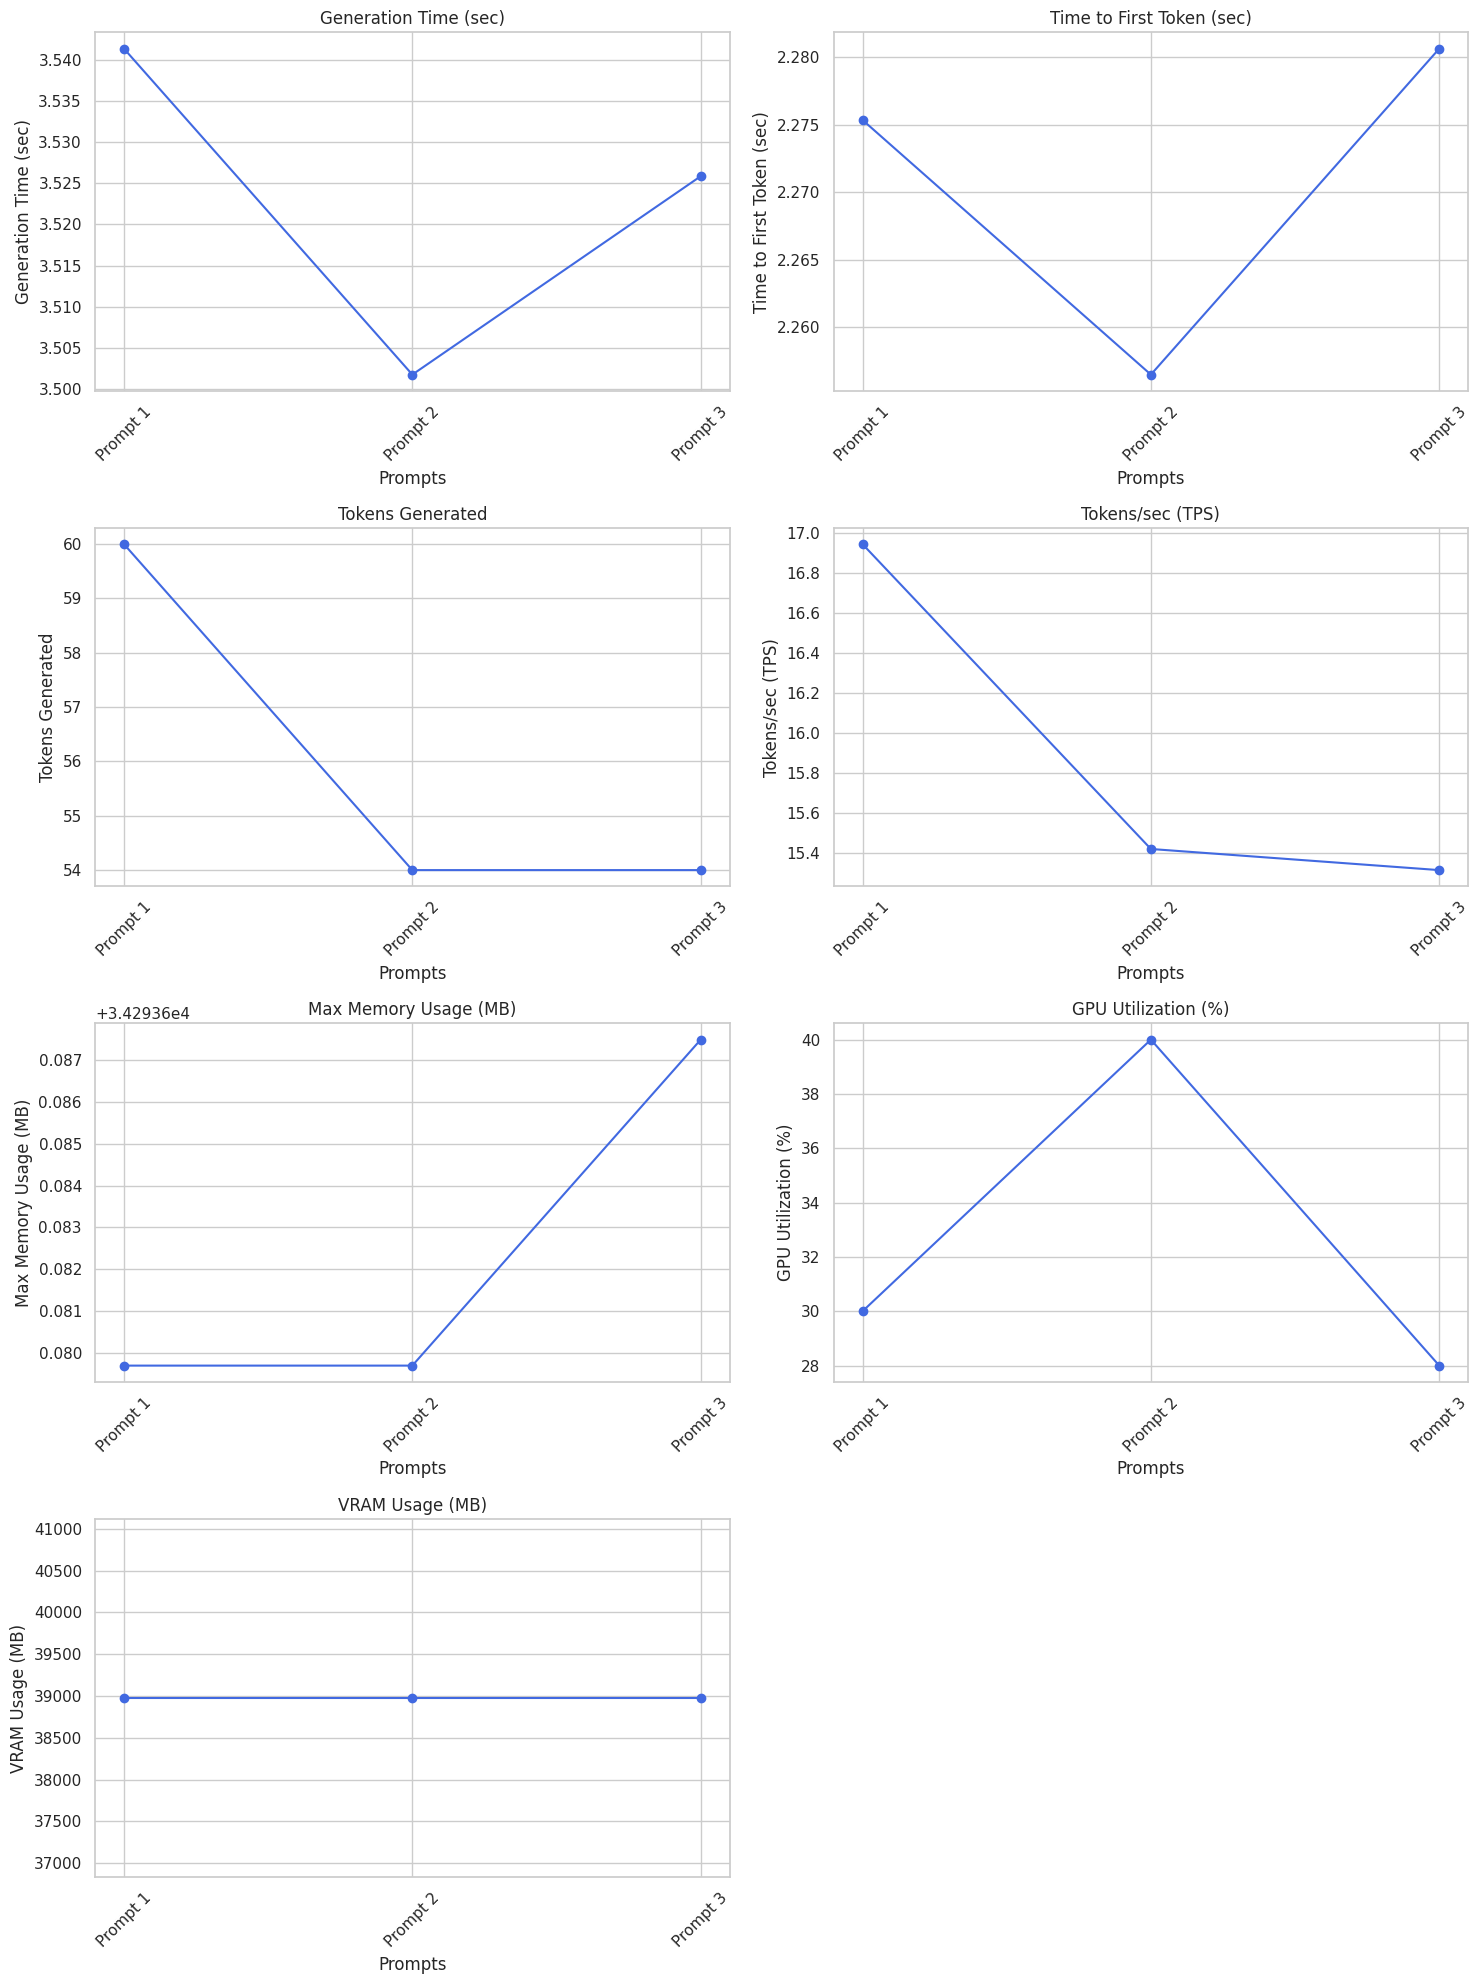

In [ ]:
results = benchmark_model(model, pipe, texts)
plot_benchmark_metrics(results)


In [ ]:
import time
import torch
import matplotlib.pyplot as plt
from transformers import pipeline, AutoProcessor, Qwen2_5_VLForConditionalGeneration
from memory_profiler import memory_usage

In [ ]:
# ----------- Load Models -----------

def load_qwen_model(model_path):
    model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
        model_path,
        torch_dtype=torch.bfloat16,
        attn_implementation="flash_attention_2",
        device_map="auto"
    )
    processor = AutoProcessor.from_pretrained(model_path)
    return pipeline("text-generation", model=model, tokenizer=processor.tokenizer)

pipe_model_1 = load_qwen_model("Qwen/Qwen2.5-VL-7B-Instruct")
pipe_model_2 = load_qwen_model("Qwen/Qwen2.5-VL-3B-Instruct")

In [ ]:
import time
import torch
import matplotlib.pyplot as plt
from transformers import pipeline, AutoProcessor, Qwen2_5_VLForConditionalGeneration
from memory_profiler import memory_usage

# ----------- Benchmarking Function (Optimized) -----------

def benchmark_prompt(pipe, prompt, max_new_tokens=50, num_return_sequences=1):
    def generate():
        return pipe(
            prompt,
            max_new_tokens=max_new_tokens,
            num_return_sequences=num_return_sequences,
            top_k=50,
            top_p=0.9,
            repetition_penalty=1.1,
            do_sample=True,
            use_cache=False
        )

    start_time = time.time()
    output, mem_usage = None, None

    # Measure memory and generation together
    def runner():
        nonlocal output
        output = generate()

    mem_usage = memory_usage((runner, ), max_usage=True)
    end_time = time.time()

    gen_time = end_time - start_time
    tokens = len(output[0]['generated_text'].split())
    tps = tokens / gen_time if gen_time > 0 else 0
    time_per_token = gen_time / tokens if tokens > 0 else 0

    print(f"\n⏱ Generation time: {gen_time:.2f} sec")
    print(f"🔠 Tokens generated: {tokens}")
    print(f"⚡ TPS: {tps:.1f} tokens/sec")
    print(f"💾 Max memory usage: {mem_usage:.2f} MB")

    return {
        "generation_time": gen_time,
        "tokens_generated": tokens,
        "tokens_per_second": tps,
        "time_per_token": time_per_token,
        "memory_usage_mb": mem_usage
    }


# ----------- Prompts -----------

texts = [
    "Once upon a time, there was a dragon who lived in a cave.",
    "The future of AI is exciting, full of possibilities.",
    "Write a short story about a wizard discovering a magical stone."
]

# ----------- Benchmarking -----------

results_model_1 = []
results_model_2 = []

print("\n=== Benchmarking Model 1 ===")
for prompt in texts:
    results_model_1.append(benchmark_prompt(pipe_model_1, prompt))

print("\n=== Benchmarking Model 2 ===")
for prompt in texts:
    results_model_2.append(benchmark_prompt(pipe_model_2, prompt))





=== Benchmarking Model 1 ===

⏱ Generation time: 2.29 sec
🔠 Tokens generated: 60
⚡ TPS: 26.2 tokens/sec
💾 Max memory usage: 2512.77 MB

⏱ Generation time: 2.33 sec
🔠 Tokens generated: 51
⚡ TPS: 21.9 tokens/sec
💾 Max memory usage: 2512.79 MB


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



⏱ Generation time: 2.28 sec
🔠 Tokens generated: 54
⚡ TPS: 23.7 tokens/sec
💾 Max memory usage: 2512.79 MB

=== Benchmarking Model 2 ===

⏱ Generation time: 2.86 sec
🔠 Tokens generated: 50
⚡ TPS: 17.5 tokens/sec
💾 Max memory usage: 2512.92 MB

⏱ Generation time: 2.82 sec
🔠 Tokens generated: 52
⚡ TPS: 18.4 tokens/sec
💾 Max memory usage: 2512.92 MB

⏱ Generation time: 2.83 sec
🔠 Tokens generated: 53
⚡ TPS: 18.7 tokens/sec
💾 Max memory usage: 2512.92 MB


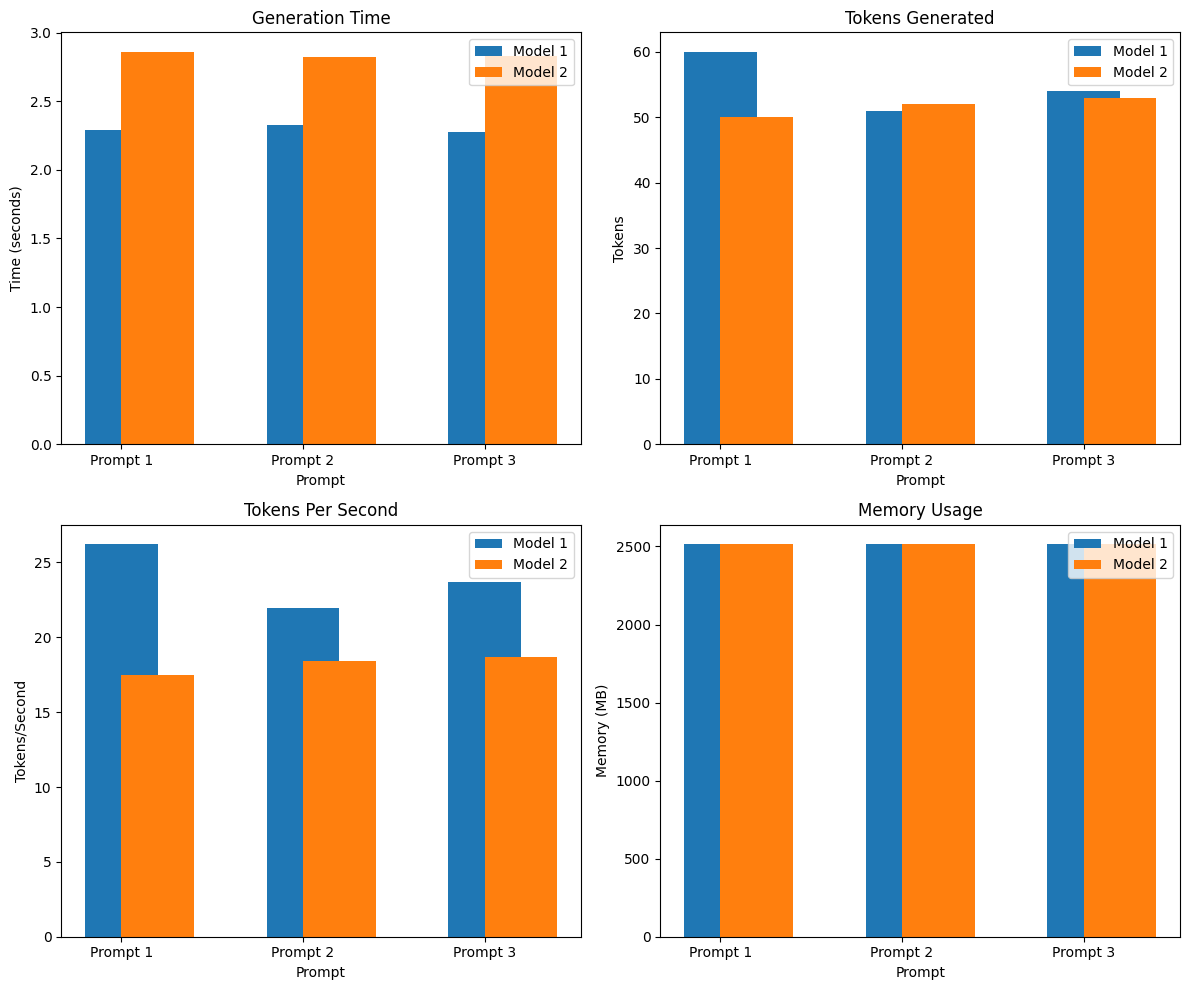

In [ ]:
import matplotlib.pyplot as plt

# Extracting the results for plotting
generation_times_model_1 = [result['generation_time'] for result in results_model_1]
tokens_generated_model_1 = [result['tokens_generated'] for result in results_model_1]
tokens_per_second_model_1 = [result['tokens_per_second'] for result in results_model_1]
memory_usage_model_1 = [result['memory_usage_mb'] for result in results_model_1]

generation_times_model_2 = [result['generation_time'] for result in results_model_2]
tokens_generated_model_2 = [result['tokens_generated'] for result in results_model_2]
tokens_per_second_model_2 = [result['tokens_per_second'] for result in results_model_2]
memory_usage_model_2 = [result['memory_usage_mb'] for result in results_model_2]

# Plotting the metrics for both models
plt.figure(figsize=(12, 10))

# Plot 1: Generation Time
plt.subplot(2, 2, 1)
plt.bar(range(len(texts)), generation_times_model_1, width=0.4, label='Model 1', align='center')
plt.bar(range(len(texts)), generation_times_model_2, width=0.4, label='Model 2', align='edge')
plt.title('Generation Time')
plt.xlabel('Prompt')
plt.ylabel('Time (seconds)')
plt.xticks(range(len(texts)), ['Prompt 1', 'Prompt 2', 'Prompt 3'])
plt.legend()

# Plot 2: Tokens Generated
plt.subplot(2, 2, 2)
plt.bar(range(len(texts)), tokens_generated_model_1, width=0.4, label='Model 1', align='center')
plt.bar(range(len(texts)), tokens_generated_model_2, width=0.4, label='Model 2', align='edge')
plt.title('Tokens Generated')
plt.xlabel('Prompt')
plt.ylabel('Tokens')
plt.xticks(range(len(texts)), ['Prompt 1', 'Prompt 2', 'Prompt 3'])
plt.legend()

# Plot 3: Tokens Per Second
plt.subplot(2, 2, 3)
plt.bar(range(len(texts)), tokens_per_second_model_1, width=0.4, label='Model 1', align='center')
plt.bar(range(len(texts)), tokens_per_second_model_2, width=0.4, label='Model 2', align='edge')
plt.title('Tokens Per Second')
plt.xlabel('Prompt')
plt.ylabel('Tokens/Second')
plt.xticks(range(len(texts)), ['Prompt 1', 'Prompt 2', 'Prompt 3'])
plt.legend()

# Plot 4: Memory Usage
plt.subplot(2, 2, 4)
plt.bar(range(len(texts)), memory_usage_model_1, width=0.4, label='Model 1', align='center')
plt.bar(range(len(texts)), memory_usage_model_2, width=0.4, label='Model 2', align='edge')
plt.title('Memory Usage')
plt.xlabel('Prompt')
plt.ylabel('Memory (MB)')
plt.xticks(range(len(texts)), ['Prompt 1', 'Prompt 2', 'Prompt 3'])
plt.legend()

plt.tight_layout()
plt.show()


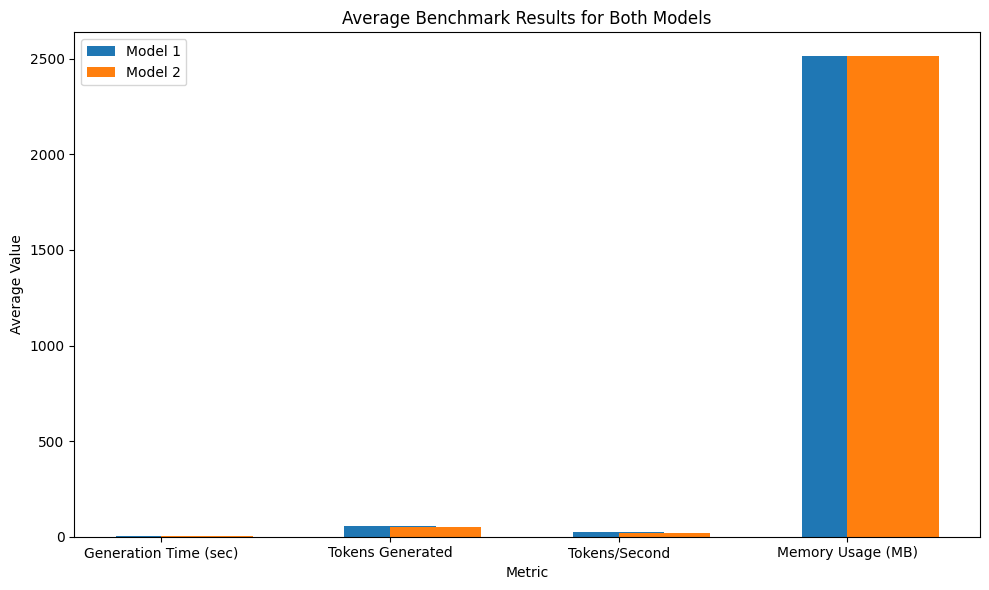

In [ ]:
import matplotlib.pyplot as plt

# Calculate the average values for each metric
avg_generation_time_model_1 = sum(generation_times_model_1) / len(generation_times_model_1)
avg_tokens_generated_model_1 = sum(tokens_generated_model_1) / len(tokens_generated_model_1)
avg_tokens_per_second_model_1 = sum(tokens_per_second_model_1) / len(tokens_per_second_model_1)
avg_memory_usage_model_1 = sum(memory_usage_model_1) / len(memory_usage_model_1)

avg_generation_time_model_2 = sum(generation_times_model_2) / len(generation_times_model_2)
avg_tokens_generated_model_2 = sum(tokens_generated_model_2) / len(tokens_generated_model_2)
avg_tokens_per_second_model_2 = sum(tokens_per_second_model_2) / len(tokens_per_second_model_2)
avg_memory_usage_model_2 = sum(memory_usage_model_2) / len(memory_usage_model_2)

# Data for plotting
metrics = ['Generation Time (sec)', 'Tokens Generated', 'Tokens/Second', 'Memory Usage (MB)']
model_1_avg = [avg_generation_time_model_1, avg_tokens_generated_model_1, avg_tokens_per_second_model_1, avg_memory_usage_model_1]
model_2_avg = [avg_generation_time_model_2, avg_tokens_generated_model_2, avg_tokens_per_second_model_2, avg_memory_usage_model_2]

# Plotting the averages for both models
plt.figure(figsize=(10, 6))

# X positions for the bars
x_pos = range(len(metrics))

# Plotting bar charts for both models
plt.bar(x_pos, model_1_avg, width=0.4, label='Model 1', align='center')
plt.bar(x_pos, model_2_avg, width=0.4, label='Model 2', align='edge')

# Adding labels, title, and legend
plt.xticks(x_pos, metrics)
plt.xlabel('Metric')
plt.ylabel('Average Value')
plt.title('Average Benchmark Results for Both Models')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()
